In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize as som

from matplotlib import colors as mcolors
from matplotlib import tri
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import host_subplot

from cpymad.madx import Madx

%matplotlib inline

import seaborn as sns

sns.set('talk', font_scale=1.2, rc={'figure.figsize':(8.3,5.2), 'lines.linewidth': 3})

sns.set_style('ticks',
               {'grid.linestyle': 'none', 'axes.edgecolor': '0',
                'axes.linewidth': 1.2, 'legend.frameon': True,
                'xtick.direction': 'out', 'ytick.direction': 'out',
                'xtick.top': True, 'ytick.right': True,
               })


In [3]:
# globals 
Qx, Qy = 18.75, 18.8
dk = 1e-3

## synchrotron lattice setup

In [4]:
match = '''match,sequence=sis100ring;
VARY,NAME=kqd,STEP=1e-8;
VARY,NAME=kqf,STEP=1e-8;
GLOBAL,sequence=sis100ring,Q1={},Q2={};LMDIF,CALLS=2000,TOLERANCE=1.0E-8;
endmatch;

twiss; '''

# input for cold lattice
cold_str = '''CALL, FILE = "Optics-YEH-Jan19-from-Elegant.str";
CALL, FILE = "sis100cold.seq";

beam, particle = ion, mass= 221.6955947052, charge=28, sequence=SIS100RING, energy = 269.29559470519996; !beta = 0.5676897813711054;
use, sequence=SIS100RING;

kqd : = -2.158585731120552e-01 * LQD;
kqf : = 2.165932886180960e-01 * LQD;

K1NL_S00QD1D:=kqd;
K1NL_S00QD1F:=kqf;
K1NL_S00QD2F:=kqf;'''

In [18]:
madx = Madx(stdout=False)

tunes = np.linspace(18.55, 18.95, 10)
twiss_cold_arr = []
for Qy in tunes:
    madx.input(cold_str + match.format(Qx, Qy))
    twiss = madx.table.twiss.dframe()
    twiss_cold_arr.append(twiss)

## select quadrupoles

In [19]:
names = [name.strip()[:-2] for name in twiss[twiss["keyword"].str.contains("quadrupole")]["name"].tolist()]

In [20]:
errors = np.random.normal(0, dk, len(names))

add_errors = ""
for name, error_val in zip(names, errors):
    add_errors += "SELECT, FLAG=error, clear;eoption, add=false;"
    add_errors += f'''SELECT, FLAG=error, PATTERN="{name}*";''' 
    add_errors += '''EFCOMP, ORDER=1, RADIUS=0.01,
    DKNR={0,''' + str(error_val) + "},DKSR={0, 0};\n"

#add_errors += "SELECT, FLAG = ERROR, FULL;ESAVE,FILE ='test';"

In [21]:
madx.input(add_errors+"twiss;")
twiss_err = madx.table.twiss.dframe()

In [22]:
# modify lattice, add more correctors!
def set_quads(theta):
    add_correctors = '''
    K1NL_S19QS1J:={};
    K1NL_S1DQS1J:={};
    K1NL_S29QS1J:={};
    K1NL_S2DQS1J:={};
    K1NL_S39QS1J:={};
    K1NL_S3DQS1J:={};
    K1NL_S49QS1J:={};
    K1NL_S4DQS1J:={};
    K1NL_S59QS1J:={};
    K1NL_S5DQS1J:={};
    K1NL_S69QS1J:={};
    K1NL_S6DQS1J:={};'''.format(*theta)
    madx.input(add_correctors + "twiss;")
    
    return madx.table.summ.q1[0], madx.table.summ.q2[0]


In [23]:
def find_betabeat(twiss_ref, twiss_curr):
    
    beat_x = np.std(twiss_curr["betx"] / twiss_ref["betx"] - 1.)
    beat_y = np.std(twiss_curr["bety"] / twiss_ref["bety"] - 1.)
    
    return np.sqrt(beat_x**2 + beat_y**2)


In [24]:
find_betabeat(twiss, twiss_err)

0.04260910571283191

In [25]:
def find_stopband(theta, twiss_ref_arr):
    out = []
    tunes = np.linspace(18.55, 18.95, 10)
    for idx, Qy in enumerate(tunes):
        set_quads(theta)
        madx.input(match.format(Qx, Qy)) # twiss after matching already there
        twiss_curr = madx.table.twiss.dframe()
        tmp = find_betabeat(twiss_ref_arr[idx], twiss_curr)
        out.append(tmp)
    return np.array(out)

In [26]:
theta0 = np.zeros(12)
theta1 = np.zeros(12)
theta1[0] = 0.02
tmp = find_stopband(theta0, twiss_cold_arr)
tmp1 = find_stopband(theta1, twiss_cold_arr)

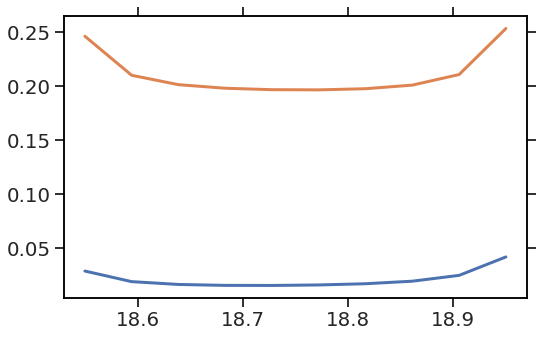

In [27]:
plt.plot(np.linspace(18.55, 18.95, 10), tmp)
plt.plot(np.linspace(18.55, 18.95, 10), tmp1)

In [28]:
def objective(theta, twiss_ref_arr, stopband_initial):
    out = np.mean(find_stopband(theta, twiss_ref_arr) / stopband_initial)
    print(out)
    return out


In [29]:
# try to replace with optuna (optionally)
method = 'COBYLA'
epsilon, ftol, catol = 5e-4, 1e-6, 1e-6

theta = np.zeros(12)

#cons = [{"type": "ineq", "fun":hyper_surface, "args":(Qx,Qy)}]
optionsDict = {'rhobeg':epsilon, 'catol':catol, "tol":ftol,'disp': True}

stopband0 = find_stopband(theta, twiss_cold_arr)
arg = (twiss_cold_arr, stopband0)

In [30]:
vec = som(objective, theta, method=method, options=optionsDict, args=arg)

0.9999865692713398
1.0386535481067725
1.0359376806474
0.9999865696294352
0.99998656927136
0.99998656927136
0.99998656927136
0.99998656927136
0.99998656927136
1.0165011742593641
0.9987873179849183
0.9987873179457301
0.9987873179457354
1.0470378818352883
1.008392681017293
0.9987873182534208
0.9961139550968993
0.9961139555251008
1.001267855439052
0.9961139557020268
1.0040056220155456
0.9961139551907958
1.0074794045897222
0.9961139558510874
1.0048214655781726
0.9961139551574272
1.0075481633208203
0.997964069408194
1.007413804186177
0.9961139558199781
1.0074138041781162
0.9961139558222868
1.0074138041780407
0.9989096385095355
0.9961139556552558
0.9976226448220059
0.9969507917836709
0.994975966604113
0.9944835614092125
0.9954402985063767
0.9944835612577464
0.9941395343311494
0.9938476408204595
0.9938476407176304
0.9938252034658405
0.9938252034873439
0.9939020224296631
0.9938252034871538
0.9939265849650638
0.9938252035538634
0.9943800510393848
0.9937922308800629
0.994114942203743
0.9937922307

In [31]:
vec

     fun: 0.9937322207255102
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 136
  status: 1
 success: True
       x: array([ 1.67929094e-05,  1.07132567e-04, -2.85926311e-05,  2.21515966e-05,
        3.12431090e-06, -8.39650265e-06,  6.79694119e-05,  2.18918412e-05,
       -2.46504543e-05,  3.51239775e-04,  4.95343564e-04,  1.81340421e-05])

In [32]:
Qx, Qy = 18.75, 18.8

madx.input(match.format(Qx, Qy))
twiss_curr = madx.table.twiss.dframe()

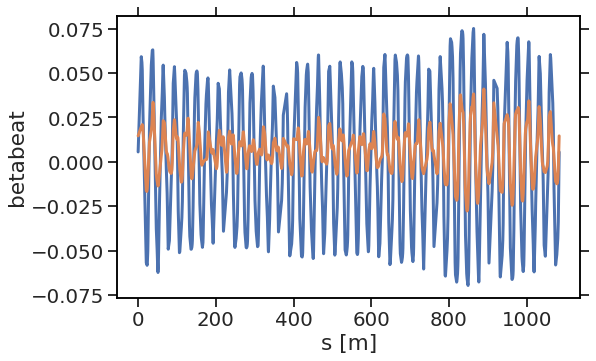

In [33]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

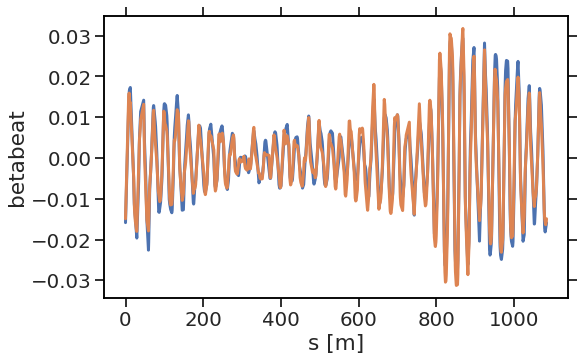

In [34]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

In [37]:
find_betabeat(twiss, twiss_err)

0.00917106660149616

In [38]:
find_betabeat(twiss, twiss_curr)

0.009175573397472075

## if we change we can remove constraints!